<a href="https://colab.research.google.com/github/LxYuan0420/aws-machine-learning-university-accelerated-nlp/blob/master/colab_notebooks/MLA_NLP_Lecture3_Neural_Networks_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Accelerator - Natural Language Processing - Lecture 3**

**Neural Networks with PyTorch**

In this notebook, we will build, train and validate a Neural Network using PyTorch.

- Implementing a neural network with PyTorch
- Loss Functions
- Training
- Example - Binary Classification
- Natural Language Processing Context

**1. Implementing a neural network with PyTorch**

(Go to top)

Let's implement a simple neural network with two hidden layers of size 64 and 128 using the sequential mode (Adding things in sequence). We will have 3 inputs, 2 hidden layers and 1 output layer. Some drop-outs attached to the hidden layers.

In [17]:
import torch
import torch.nn as nn
import time

In [2]:
net = nn.Sequential(
    nn.Linear(in_features=3, out_features=64),
    nn.Tanh(),
    nn.Dropout(p=.4),
    nn.Linear(64,64),
    nn.Tanh(), 
    nn.Dropout(p=.3),
    nn.Linear(64,1),
)

print(net)

Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)


In [5]:
# initialize weights
def xavier_init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

net.apply(xavier_init_weights)

Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)

In [6]:
print(net[0])
print(net[1])
print(net[2])
print(net[3])
print(net[4])

Linear(in_features=3, out_features=64, bias=True)
Tanh()
Dropout(p=0.4, inplace=False)
Linear(in_features=64, out_features=64, bias=True)
Tanh()


**2. Loss Functions**

(Go to top)

We can select loss functions according to our problem. A full list of supported Loss functions in PyTorch are available here.

Let's go over some popular loss functions and see how to call a built-in loss function:

Binary Cross-entropy Loss: A common used loss function for binary classification.

loss = nn.BCELoss()
Categorical Cross-entropy Loss: A common used loss function for multi-class classification.

loss = nn.CrossEntropyLoss()
MSE Loss: One of the most common loss functions for regression problems.

loss = nn.MSELoss()
L1 Loss: This is similar to L2 loss. It measures the abolsute difference between target values (y) and predictions (p).$$
\mathrm{L1 loss} = \frac{1}{2} \sum_{examples}|y - p|
$$In pytorch, we can use it with L1Loss:

loss = nn.L1Loss()

**3. Training**

(Go to top)

torch.optim module provides necessary optimization algorithms for neural networks. We can use the following Optimizers to train a network using Stochastic Gradient Descent (SGD) method and learning rate of 0.001.

In [7]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

**4. Example - Binary Classification**

(Go to top)

Let's train a neural network on a random dataset. We have two classes and will learn to classify them.

In [8]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=750, shuffle=True, random_state=42, noise=0.05, factor=0.3)

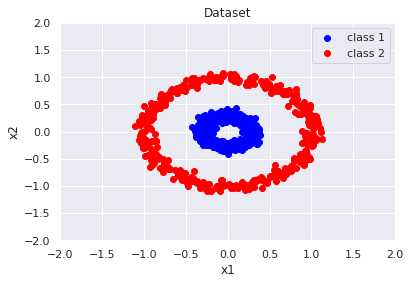

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dataset(X, y, title):
    
    # Activate Seaborn visualization
    sns.set()
    
    # Plot both classes: Class1->Blue, Class2->Red
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', label="class 1")
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', label="class 2")
    plt.legend(loc='upper right')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.title(title)
    plt.show()
    
plot_dataset(X, y, title="Dataset")

---

In [10]:
net = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)

In [11]:
batch_size = 4
epochs = 50
learning_rate = 0.01
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loss = nn.BCELoss(reduction="none")
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [15]:
X_train, X_val = X[0:int(len(X)*0.8), :], X[int(len(X)*0.8):, :]
y_train, y_val = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

# use PyTorch DataLoaders to load the data in batches
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

# move validation dataset on CPU/GPU device
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [18]:
# start training

train_losses = []
val_losses = []

for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    for idx, (data, target) in enumerate(train_loader):
        #zero paramater gradients
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device).view(-1, 1)
        
        output = net(data)
        L = loss(output, target).sum()
        training_loss += L.item()
        L.backward()
        optimizer.step()

    # get validation preds
    val_predictions = net(X_val)
    val_loss = torch.sum(loss(val_predictions, y_val.view(-1, 1))).item()

    # take the average losses
    training_loss = training_loss / len(y_train)
    val_loss = val_loss / len(y_val)

    train_losses.append(training_loss)
    val_losses.append(val_loss)

    end = time.time()
    print(f"Epoch-{epoch} Train loss: {training_loss}  Validation loss: {val_loss}  Time(sec): {end-start}")

Epoch-0 Train loss: 0.6903538854916891  Validation loss: 0.6860828653971354  Time(sec): 0.2354276180267334
Epoch-1 Train loss: 0.6807338694731394  Validation loss: 0.6727889506022136  Time(sec): 0.11622786521911621
Epoch-2 Train loss: 0.6576992348829905  Validation loss: 0.6446551005045573  Time(sec): 0.11269307136535645
Epoch-3 Train loss: 0.6111911326646805  Validation loss: 0.5929249064127604  Time(sec): 0.10860466957092285
Epoch-4 Train loss: 0.5368986217180888  Validation loss: 0.5236824035644532  Time(sec): 0.11224174499511719
Epoch-5 Train loss: 0.4499088157216708  Validation loss: 0.44088109334309894  Time(sec): 0.10656237602233887
Epoch-6 Train loss: 0.350503372947375  Validation loss: 0.3309692128499349  Time(sec): 0.11458945274353027
Epoch-7 Train loss: 0.23192666252454122  Validation loss: 0.20286368052164713  Time(sec): 0.10623645782470703
Epoch-8 Train loss: 0.12362749521931013  Validation loss: 0.10580285390218098  Time(sec): 0.12323284149169922
Epoch-9 Train loss: 0.063

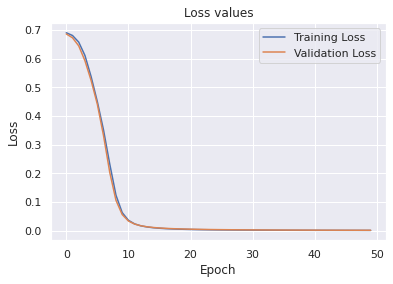

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()